# Refinement

Refine the model trained in DF_Filter.015

Directory structure is
* cache  
    * train  
        * 0  (green) 2680 files
        * 1   (blue) 3099 files
    * valid  
        * 0  (green) 266 files
        * 1   (blue) 311 files

Filename like F5..208 or F15.209.tif i.e. original_image.patch num.tif  
All prefixes are 3 characters with either one or two dots.  
Patch nums are per category.  
Each file holds a 224x224 patch of a color image.

In [1]:
import time
import os
#  os.environ['CUDA_VISIBLE_DEVICES'] = "0"   # turns off GPU?
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
from tensorflow import keras
import keras.layers as kl
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
DIR_IMAGES_IN = "/home/jrm/Martinez/images/cache/"
PATCH_SIZE=224  # matches VGG
BLUE=1
GREEN=0

In [3]:
train_dir = os.path.join(DIR_IMAGES_IN, 'train')
valid_dir = os.path.join(DIR_IMAGES_IN, 'valid')

BATCH_SIZE = 32
IMG_SIZE = (224,224)

train_dataset = keras.utils.image_dataset_from_directory(
    train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = keras.utils.image_dataset_from_directory(
    valid_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 5779 files belonging to 2 classes.
Found 577 files belonging to 2 classes.


In [4]:
iterator = valid_dataset.take(1)
for x in iterator:
    print(x[0].shape)
    print(x[1])

(32, 224, 224, 3)
tf.Tensor([0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0], shape=(32,), dtype=int32)


In [5]:
# TO DO: normalize color channel ints to floats (0,1)
# See https://www.tensorflow.org/tutorials/load_data/images

normalization_layer = kl.Rescaling(1./255)

In [18]:
ACTIVATION="tanh"
NUM_CLASSES = 2
CHANNELS=3
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,CHANNELS]
cnn = keras.models.Sequential([
    kl.Conv2D(64,5,activation=ACTIVATION,padding="SAME",input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.Conv2D(64,5,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(64,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(32,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(NUM_CLASSES,activation="softmax")
])
# Almost no learning with all Conv layers using 64x7.
# Hits 99% by epoch 2 using all Conv layers 64x5.
# Takes more time (20s/epoch) with Conv(128,7) followed by Conv(64,7) but reaches 99%.
# Takes less time (16s/epoch) with 1x64,5 and 2x128,5 and hits 99% by epoch 2.

In [19]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=10
start = time.time()
hist = cnn.fit(train_dataset,validation_data=valid_dataset,epochs=EPOCHS)
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/10
181/181 [==============================] - 12s 64ms/step - loss: 0.2290 - accuracy: 0.9114 - val_loss: 0.0345 - val_accuracy: 0.9931
Epoch 2/10
181/181 [==============================] - 11s 61ms/step - loss: 0.0317 - accuracy: 0.9926 - val_loss: 0.0291 - val_accuracy: 0.9931
Epoch 3/10
181/181 [==============================] - 11s 62ms/step - loss: 0.0231 - accuracy: 0.9948 - val_loss: 0.0152 - val_accuracy: 0.9948
Epoch 4/10
181/181 [==============================] - 11s 62ms/step - loss: 0.0151 - accuracy: 0.9965 - val_loss: 0.0215 - val_accuracy: 0.9948
Epoch 5/10
181/181 [==============================] - 11s 62ms/step - loss: 0.0145 - accuracy: 0.9960 - val_loss: 0.0180 - val_accuracy: 0.9948
Epoch 6/10
181/181 [==============================] - 11s 62ms/step - loss: 0.0138 - accuracy: 0.9967 - val_loss: 0.0170 - val_accuracy: 0.9948
Epoch 7/10
181/181 [==============================] - 11s 62ms/step - loss: 0.0117 - accuracy: 0.9969 - val_loss: 0.0151 - val_accuracy:

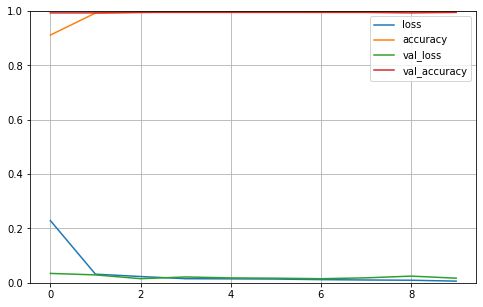

In [20]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()